# 1

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import lfd
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely import LineString, multilinestrings

In [ ]:
data, x, xd = lfd.load_data("s")
dset = lfd.append_progress_values([LineString(traj) for traj in data])

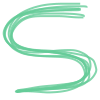

In [4]:
multilinestrings(dset)

In [5]:
lfd.compute_A(dset)

array([[  0, 311, 367, 344, 387, 455, 323],
       [301,   0, 469, 430, 449, 546, 365],
       [359, 468,   0, 224, 238,  45, 153],
       [330, 438, 218,   0, 225, 214, 708],
       [351, 441, 212, 202,   0, 240, 177],
       [427, 559,  22, 207, 252,   0, 177],
       [320, 369, 168, 729, 233, 215,   0]])

<Axes: >

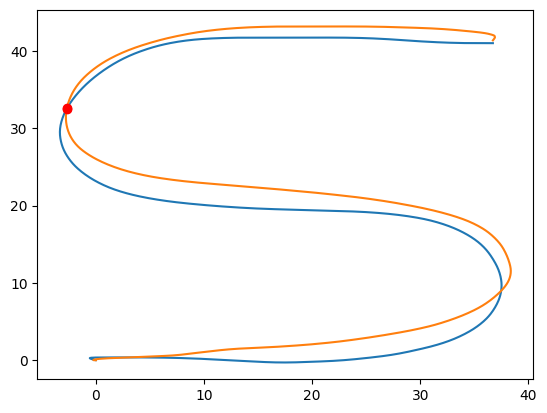

In [6]:
lfd.plot_index_points(dset, indices=[0, 1], only_between=True)

<Axes: >

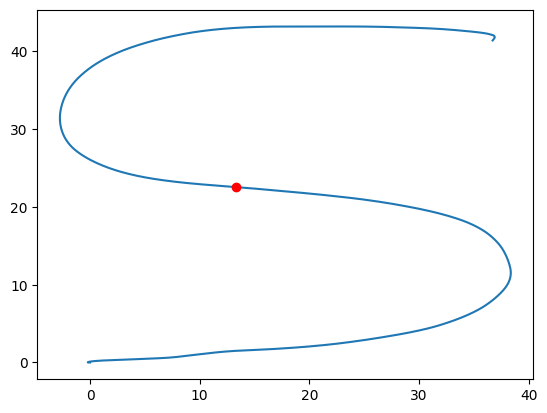

In [7]:
lfd.plot_keypoints(dset, indices=[1])

In [8]:
f1 = lfd.Frame(index=1, rotation=10, translation=(5, 5))

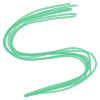

In [9]:
dset_f1 = f1.transform(dset)
multilinestrings(dset_f1)

<Axes: >

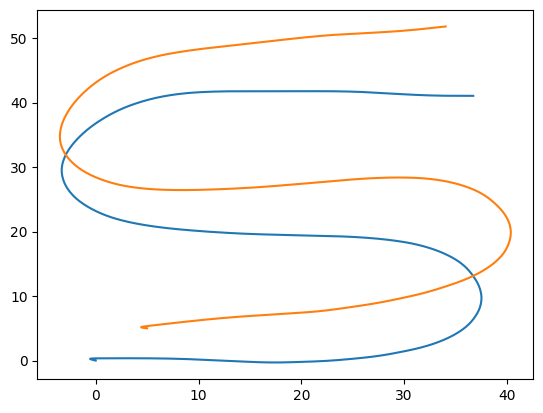

In [10]:
lfd.plot_trajectories([dset[0], dset_f1[0]])

In [11]:
# P = lfd.compute_P(dset)
# P

In [12]:
# P_f1 = lfd.compute_P(dset_f1)
# P_f1

In [13]:
# A = lfd.compute_A(dset)
# A

In [14]:
# A_f1 = lfd.compute_A(dset_f1)
# A_f1

In [15]:
# lfd.resample(dset, frames=[f1])

In [16]:
# i, j = 0, 1
# intersection = dset[i].intersection(dset[j])
# shapely.get_parts(intersection)

In [17]:
# def compute_h_2(dset: lfd.DemonstrationSet, i: int, j: int, th=10) -> Tuple[int, int]:
#     dist = cdist(dset[i].coords, dset[j].coords)
#     indices = np.unravel_index(np.argsort(dist.ravel()), dist.shape)
#     return [(dist[i, j], i, j) for i, j in zip(*indices)], indices
#     min_ind = np.min(ind, axis=0)
#     for r, (i, j) in enumerate(zip(*ind)):
#         if abs(i - min_ind[r]) <= th and abs(j - min_ind[r]) <= th:
#             return i, j
#     return ind[0][0], ind[1][0]

In [18]:
# a, d = compute_h_2(dset, 0, 1, th=100)
# a

In [19]:
# b = np.array(a)
# b

In [20]:
# c = b[:, 1:]
# c

In [21]:
# np.min(c, axis=1)

In [22]:
# d[0]

In [23]:
al_dset = lfd.resample(dset, frames=[f1])
al_dset

[<LINESTRING Z (36.715 41.034 0, 36.715 41.034 0.001, 36.714 41.034 0.002, 36...>,
 <LINESTRING Z (36.715 41.394 0, 36.755 41.461 0.001, 36.791 41.526 0.002, 36...>,
 <LINESTRING Z (34.555 44.994 0, 34.589 45.053 0.001, 34.62 45.111 0.002, 34....>,
 <LINESTRING Z (34.915 48.593 0, 34.914 48.593 0.001, 34.911 48.593 0.002, 34...>,
 <LINESTRING Z (34.555 45.354 0, 34.555 45.337 0.001, 34.554 45.32 0.002, 34....>,
 <LINESTRING Z (34.555 46.074 0, 34.553 46.051 0.001, 34.549 46.029 0.002, 34...>,
 <LINESTRING Z (38.515 46.434 0, 38.514 46.466 0.001, 38.512 46.498 0.002, 38...>]

In [24]:
np.stack([list(d.coords) for d in al_dset]).shape

(7, 1000, 3)

In [25]:
def prepare_data(dset, include_phi: bool = True):
    """
    Turn a list of LineString(Z) of shape (N demos, L points, 3 coords)
    into X and Y matrices for GP training:
      X: [ξ, φ] at time t
      Y: Δξ = ξ(t+1) − ξ(t), Δφ = φ(t+1) − φ(t)
    """
    arr = np.stack([np.array(d.coords) for d in dset])  # (N, L, 3)
    N, L, _ = arr.shape

    if include_phi:
        X = arr[:, :-1, :]  # (N, L−1, 3)
        Y = arr[:, 1:, :] - X  # (N, L−1, 3)
    else:
        X = arr[:, :-1, :2]  # (N, L−1, 2)
        Y = arr[:, 1:, :2] - X  # (N, L−1, 2)

    # flatten demos & timesteps
    X_flat = X.reshape(-1, 3)  # (N*(L−1), 2)
    Y_flat = Y.reshape(-1, 3)  # (N*(L−1), 2)
    return X_flat, Y_flat

In [26]:
# say you only have one extra frame f1 for now:
frames = [lfd.GlobalFrame, f1]
local_policies = {}

for m, frame in enumerate(frames):
    # transform the *aligned* global demos into frame m
    dset_m = frame.transform(al_dset)
    X_m, Y_m = prepare_data(dset_m, include_phi=False)

    # pick M inducing points (e.g. 50) randomly from X_m
    M = 50
    idx = np.random.choice(len(X_m), size=M, replace=False)
    Xu = X_m[idx]

    # instantiate and train
    gp_m = lfd.LocalPolicyGP(X_m, Y_m, Xu, noise=1e-2, lr=5e-3)
    gp_m.train(num_steps=1000, log_every=200)

    local_policies[m] = gp_m

[LocalPolicyGP] Step 0 ELBO loss: 12958.8034
[LocalPolicyGP] Step 200 ELBO loss: -13911.5658
[LocalPolicyGP] Step 400 ELBO loss: -13826.1894
[LocalPolicyGP] Step 600 ELBO loss: -13802.4359
[LocalPolicyGP] Step 800 ELBO loss: -14019.2599
[LocalPolicyGP] Step 0 ELBO loss: -10712.2613
[LocalPolicyGP] Step 200 ELBO loss: -11743.0832
[LocalPolicyGP] Step 400 ELBO loss: -11323.9988
[LocalPolicyGP] Step 600 ELBO loss: -10789.7247
[LocalPolicyGP] Step 800 ELBO loss: -10756.7216


In [27]:
m = 0
means_m, vars_m = local_policies[m].predict(X_m)

In [28]:
means_m

array([[-0.0427482 ,  0.        ,  0.        ],
       [ 0.00010417,  0.        ,  0.        ],
       [-0.04276977,  0.        ,  0.        ],
       ...,
       [-0.08041777,  0.        ,  0.        ],
       [-0.08354349,  0.        ,  0.        ],
       [-0.08224232,  0.        ,  0.        ]],
      shape=(4662, 3), dtype=float32)

In [29]:
vars_m

array([[0.00859543, 0.01248332, 0.01248332],
       [0.04261666, 0.03291148, 0.03291148],
       [0.00859559, 0.0124834 , 0.0124834 ],
       ...,
       [0.00588153, 0.00919563, 0.00919563],
       [0.0056279 , 0.00900872, 0.00900872],
       [0.00572398, 0.00947222, 0.00947222]],
      shape=(4662, 3), dtype=float32)

In [30]:
# Re‑prepare the global (aligned) dataset into inputs X_glob and true deltas Δ_glob
X_glob, Y_glob = prepare_data(al_dset)
# X_glob: (N, 3) ← [x, y, φ],   Y_glob: (N, 3) ← Δ[x,y,φ]

# split into features
phi = X_glob[:, 2]  # shape (N,)
deltas = Y_glob  # shape (N, D_out)

In [31]:
# Query each local GP on the *same* X_glob to get local means & vars
all_means = []
all_vars = []
for m, gp_m in sorted(local_policies.items()):
    mu_m, var_m = gp_m.predict(X_glob)  # each → (N, D_out)
    all_means.append(mu_m)
    all_vars.append(var_m)

# stack into shape (N, num_frames, D_out)
local_means = np.stack(all_means, axis=1)
local_vars = np.stack(all_vars, axis=1)

In [32]:
# Choose M inducing‐points along φ ∈ [0,1], e.g. 20 evenly spaced
M = 20
Xu_phi = np.linspace(0, 1, M)
num_frames = len(local_policies)

frgp = lfd.FrameRelevanceGP(
    phi=phi,
    num_frames=num_frames,
    Xu=Xu_phi,
    noise=1e-2,
    lr=1e-2,
)

In [33]:
# Self‑supervised train relevance GP
frgp.train(
    phi=phi,
    local_means=local_means,
    local_vars=local_vars,
    deltas=deltas,
    num_steps=2000,
    log_every=200,
)

[FrameRelevanceGP] Step 0 NLL: -42183.2188
[FrameRelevanceGP] Step 200 NLL: -42903.7031
[FrameRelevanceGP] Step 400 NLL: -42935.3398
[FrameRelevanceGP] Step 600 NLL: -42957.8750
[FrameRelevanceGP] Step 800 NLL: -42977.3398
[FrameRelevanceGP] Step 1000 NLL: -42995.8164
[FrameRelevanceGP] Step 1200 NLL: -43014.9727
[FrameRelevanceGP] Step 1400 NLL: -43035.8477
[FrameRelevanceGP] Step 1600 NLL: -43058.7109
[FrameRelevanceGP] Step 1800 NLL: -43083.2422


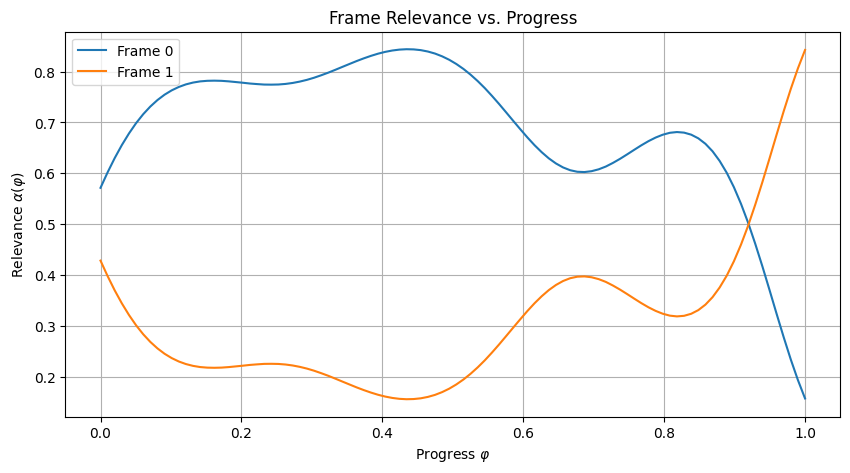

In [34]:
# Inspect learned relevance α(φ)
phi_test = np.linspace(0, 1, 100)
alpha = frgp.predict(phi_test)  # shape (100, num_frames)

# Plot of each column of alpha vs. φ to see which frame is active when.
plt.figure(figsize=(10, 5))
for i in range(num_frames):
    plt.plot(phi_test, alpha[:, i], label=f"Frame {i}")
plt.xlabel(r"Progress $\varphi$")
plt.ylabel(r"Relevance $\alpha(\varphi)$")
plt.title("Frame Relevance vs. Progress")
plt.legend()
plt.grid()
plt.show()